In [1]:
%matplotlib inline

# CTA Data: Poles of Isolation

A while back I saw an interesting article on ["poles of isolation" (aka "poles of inaccessability")](https://en.wikipedia.org/wiki/Pole_of_inaccessibility). The term _pole of isolation_ is a somewhat archaic term for a very landlocked place. It just so happens that my home state (South Dakota) is a particularly "isolated" place by this metric (you can see this for yourself [here](https://upload.wikimedia.org/wikipedia/commons/a/ad/Distancia_a_la_costa.png)).

This got me thinking about my *current* home, Chicago, IL. I had been talking with my wife some days prior about how awful it must be to live far from a train. In Chicago, the "El" is a modern equivalent to seafaring -- if you aren't near the el, you aren't going to get anywhere fast (if at all). The natural question, then, is what are Chicago's poles of inaccessibility?

The short answer is: exactly where you expect, and exactly where residents would need it most.

## The Data

For most of this data in this project I am indebted to the good folks over at the [City of Chicago Data Portal](https://data.cityofchicago.org/). In particular, there are [quite a few awesome data sets](https://data.cityofchicago.org/Transportation/CTA-List-of-CTA-Datasets/pnau-cf66) regarding the Chicago Transit Authority (CTA). I used a couple from this collection (lists of stations, their latitude/longitude locations), as well as a pretty nifty city border KML file. The details can be found in the `bootstraph.sh` script which collects them.

I have put separated the different conceptual objects into different modules, so let me quickly go through those modules and their uses here.

### `citybounds.py`

In [2]:
import cta.citybounds as citybounds

This module is designed to handle the acquisition and manipulation of the geospatial boundaries of the city of Chicago. The kml file stipulating these boundaries is downloaded by the `bootstrap.sh` script:

```bash
bash bootstraph.sh
```

and then the csv file will be created via the function `kml_to_csv`:

In [3]:
citybounds.kml_to_csv()

With that part done, we can now load the city boundaries and do some fancy plotting magix

In [4]:
bpath = citybounds.load_boundary()
bpath.head()

,loop,latitude,longitude
0,0,42.0213,-87.6642
1,0,42.0213,-87.6642
2,0,42.0213,-87.6640
3,0,42.0207,-87.6639
4,0,42.0207,-87.6639


The `loop` variable is referring to "loop" in the geoinformatic sense; Chicago's boundary is composed of three outer loops of (latitude, longitude) coordinates and three inner loops.

Coincidentally, learning about those three outer loops was pretty fun -- one, on the far southwest side, is a cemetery called Mount Greenwood Cemetery. It is not a city at all, but rather just an unincorporated tract of land in the greater Cook County.

I haven't been ablve to figure out what the northernmost inner track in Chicago (just north of Norridge and Harwood Heights), so bonus points to anyone who knows what that place is.


That being said, forget about those places -- I am focused primarily on residents of the city of Chicago. As such, I've created a method which will give me a semi-sparse grid of only points that lay within the city limits:

In [5]:
grid = citybounds.build_grid()
grid.head()

,latitude,longitude
0,41.648323,-87.616544
1,41.648323,-87.612342
2,41.648323,-87.608140
3,41.648323,-87.603938
4,41.648323,-87.599736


The above method is parsing the csv of boundary points and building the boundary data frame, converting the boundary items into `matplotlib.path` polygon objects, and returning a collection of evenly spaced (in lat and lng) points that lay within those polygons.

This scatter plot should look familiar enough for residents of the Windy City:

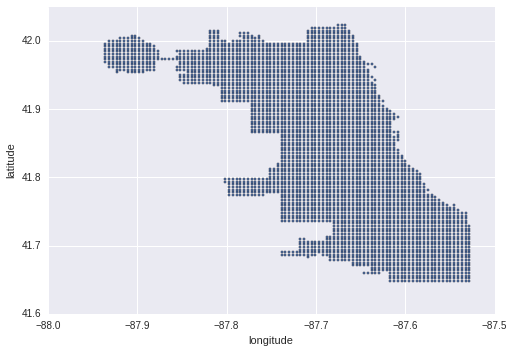

In [6]:
import seaborn as sns
grid.plot('longitude', 'latitude', kind='scatter', marker='.')

### `trains.py`

In [7]:
import cta.trains as trains

To find the distance of each of the above points to a train station, I need to know where the trains are, don't I? Simple enough task, again thanks to the City of Chicago Data Portal: I can pull the train info direct from their RESTful API.

In [8]:
stations = trains.lstation_data()
stations.head()

,ada,blue,brn,color,direction_id,g,latitude,longitude,map_id,needs_recording,o,p,pexp,pnk,red,station_descriptive_name,station_name,stop_id,stop_name,y
0,True,False,False,pnk,W,False,41.857908,-87.669147,40830,None,False,False,False,True,False,18th (Pink Line),18th,30162,18th (54th/Cermak-bound),False
1,True,False,False,pnk,E,False,41.857908,-87.669147,40830,None,False,False,False,True,False,18th (Pink Line),18th,30161,18th (Loop-bound),False
2,True,False,False,o,N,False,41.829353,-87.680622,40120,None,True,False,False,False,False,35th/Archer (Orange Line),35th/Archer,30022,35th/Archer (Loop-bound),False
3,True,False,False,o,S,False,41.829353,-87.680622,40120,None,True,False,False,False,False,35th/Archer (Orange Line),35th/Archer,30023,35th/Archer (Midway-bound),False
4,True,False,False,g,S,True,41.831677,-87.625826,41120,None,False,False,False,False,False,35th-Bronzeville-IIT (Green Line),35th-Bronzeville-IIT,30214,35-Bronzeville-IIT (63rd-bound),False


As always, there is some cleanup involved ("Ran Ryan" is a stop? You sure about that?).

Every physical train station in the above has two or more lines associated with it for the two or more outbound tracks (some have four). There also is no semblence of order to those stations, so I had to build that myself.

In [9]:
stationorder = trains.station_order()
stationorder['brn'][:10]

['Kimball (Brown Line)',
 'Kedzie (Brown Line)',
 'Francisco (Brown Line)',
 'Rockwell (Brown Line)',
 'Western (Brown Line)',
 'Damen (Brown Line)',
 'Montrose (Brown Line)',
 'Irving Park (Brown Line)',
 'Addison (Brown Line)',
 'Paulina (Brown Line)']

In [10]:
oldcols = set(stations.columns)
trains.add_line_order(stations, stationorder)
newcols = set(stations.columns)
print "len(oldcols) = {}".format(len(oldcols))
print "len(newcols) = {}".format(len(newcols))
print "difference   = {}".format(newcols.difference(oldcols))

len(oldcols) = 20
len(newcols) = 21
difference   = set(['line_order'])


In [11]:
stations[['station_descriptive_name', 'line_order']].head()

,station_descriptive_name,line_order
0,18th (Pink Line),9
1,18th (Pink Line),9
2,35th/Archer (Orange Line),4
3,35th/Archer (Orange Line),4
4,35th-Bronzeville-IIT (Green Line),21


Of course, this dataframe isn't itself ordered by line order -- I've written a function for that. Overkill, I know

In [12]:
orderedstations = trains.ordered_stations(stations)
orderedstations[['station_descriptive_name', 'line_order']].head()

,station_descriptive_name,line_order
235,O'Hare (Blue Line),0
234,O'Hare (Blue Line),0
263,Rosemont (Blue Line),1
262,Rosemont (Blue Line),1
101,Cumberland (Blue Line),2


Once you have loaded the locations of the stations, you could, theoretically, plot the train lines. Of course, that's a pipe dream -- every denizen of a CTA rail car knows that going in a straight line from station to station is reserved for interstate tracks. For the rest of us, we have a serpentine route from A to B. To get that route down exactly, we rely, again, on our good friends at the CoCDP, who have exposed the track locations to us as a KML file (downloaded at installation by `bootstraph.sh`)

In [13]:
llines = trains.load_line_coords()
llines[0]

{'ASSET_ID': '21100006',
 'DESCRIPTION': 'Clark Junction to Belmont',
 'LEGEND': 'RD',
 'RAIL LINES': 'Brown, Purple (Express), Red',
 'SEGMENT_ID': '6',
 'TYPE': 'Elevated or at Grade',
 'coords':    altitude   latitude  longitude
 0         0  41.942177 -87.653454
 1         0  41.941852 -87.653442
 2         0  41.941457 -87.653423
 3         0  41.940832 -87.653397
 4         0  41.939914 -87.653383
 5         0  41.939751 -87.653380,
 'kml_color': 'ff0000ff',
 'name': 'Brown, Purple (Express), Red',
 'rgba_color': {'a': 'ff', 'b': '00', 'g': '00', 'r': 'ff'},
 'styleUrl': '#LineStyle00'}

The above could probably be parsed into a way more awesomer dataframe, but as it was, just getting individual end-to-end rail tracks into data frames in some iterable fashion was good enough for the time being.

### `poleofisolation.py`

In [14]:
import cta.poleofisolation as poleofisolation

Finally, we have our grid of "residents" in the city of Chicago, and we have our train stations and other plottable goodies -- let's acctually calculate some distances with `poleofisolation`.

The function `isolation_distances` expects one of each of the above (a `grid` of starting locations with at least a `latitude` and a `longitude` variable, and a `stations` dataframe with the same). It then proceeds to calculate the distance between the two (lat, lng) pairs using the [haversine formula](https://en.wikipedia.org/wiki/Haversine_formula).

In [15]:
isodists = poleofisolation.isolation_distances(grid, stations)
isodists.head()

,latitude,longitude,rlatitude,rlongitude,shortest_distance
0,41.648323,-87.616544,0.7269,-1.529197,5.138136
1,41.648323,-87.612342,0.7269,-1.529124,5.159692
2,41.648323,-87.608140,0.7269,-1.529051,5.190244
3,41.648323,-87.603938,0.7269,-1.528977,5.229635
4,41.648323,-87.599736,0.7269,-1.528904,5.277667


The columns `rlatitude` and `rlongitude` have been introduced in the process of calculating the distance (the haversine formula requires angles in radians, and it was simpler to do that vectorize than one at a time thanks to `scipy`).

## The Plots

All of the above methods are called into play in the central plotting package, `mapplots`

In [16]:
import cta.mapplots as mapplots

I've broken up the plotting process into four main steps:

1. `add_isolation_dist_colormap`: Plotting the isolation dists information as a meshed contour map
2. `add_boundary`: Plotting the boundary of the city
3. `add_stations`: Plotting station locations
4. `add_l_lines`: Plotting train lines

Of these, only the 3rd and 4th are very straightforward. The 1st and 2nd require some work.

Because we chose to only consider a grid of points within the city boundaries, we are really working with a mesh, and not an array. The `contour` and `contourf` plotting methods within `matplotlib` don't play nice with non-array data being treated like an array.

The **do**, however, play nice with `scipy.meshgrid` objects. `pandas` makes this easy enough: one quick pivot gives us an object with the three pieces we need:

```python
ipiv = isodists.pivot('longitude', 'latitude', 'shortest_distance')
x = ipiv.columns.values
y = ipiv.index.values
z = ipiv.values
xi, yi = scipy.meshgrid(x, y)
c = subplot.contourf(yi, xi, z, N, cmap=plt.get_cmap('coolwarm_r'), **kwarg)
```

As for the boundary, as I mentioned above we have a boundary with both inner and outer loops. Out of the box, matplotlib will plot this with connections between the loops, resulting in giant shards running from O'Hare to the south side. I think everyone would love if there really were some physical straight-shot connection between Mount Greenwood and O'Hare, but there isn't, so let's not pretend there is. The solution is to group the boundary data frame by the `loop` variable, and use `pandas` built-in integration with matplotlib for groupby objects

```python
grouped = bpath.groupby('loop')
grouped.plot('longitude', 'latitude', style='k-', legend=False, ax=subplot)
```


With all of this done, we can create our primary plot.

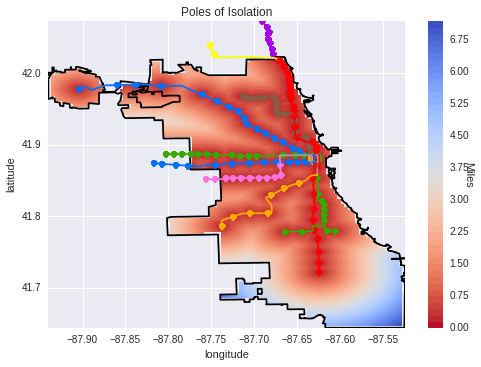

In [18]:
f = mapplots.main(bpath=bpath, grid=grid, orderedstations=orderedstations, llines=llines, isodists=isodists)

As you can see, the areas most distant from the CTA are largely south-side neighborhoods, with the addition of quite a few neighborhoods in west/north-west Chicago. Naively, this would seem to correlate well with areas with low income families. I haven't done the full analaysis yet, of course, so I can't say that with any really definitive weight. For a back-and-forth visual comparison, check out [this intereactive map](http://www.city-data.com/income/income-Chicago-Illinois.html) at city-data.com.

One other interesting observation: I haven't collected Metra information yet, but I think that the long white streak which is equidistant between the blue and green lines on the upper northwest side of the city may well be covered, almost exactly, by the MD-W line.